# Quickstart Example with Synthetic RTB Simulation and Dataset (Discrete)
This notebook provides an example of conducting **Off-policy Evaluation (OPE) and Offline Reinforcement Learning (Offline RL) with synthetic Real-Time Bidding (RTB) dataset**.

Our example with Synthetic RTB Simualtion and Dataset contains the following 5 steps:
0. (Setup Synthetic RTB Simulation Environment and Online RL)
1. Synthetic Data Generation
2. Offline Reinforcement Learning
3. Off-Policy Evaluation and Evaluation of Offline RL methods
4. Evaluation of OPE methods

We also show how to visualize the results in Appendix.

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of online/offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import _gym modules
import _gym
from _gym.env import RTBEnv, CustomizedRTBEnv
from _gym.dataset import SyntheticDataset
from _gym.policy import OnlineHead, DiscreteEpsilonGreedyHead
from _gym.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(_gym.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

## 0. (Setup Synthetic RTB Simulation Environment and Online RL)
To begin with, we briefly describe how the RTB environment works for the preparation.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as numbers of click or conversion) within a episode under the given budget constraints.  
We often try to achieve this by adjusting bidding price function parameter :math:`\alpha`. By using :math:`\alpha`, we adjust bid price as follows.  
:math:`bid_{t,i} = \alpha * r*`, 
where :math:`r*` denotes predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe statistical feedback from environment at each timestep, which include following informations.
  - timestep
  - remaining budget
  - impression level features (budget comsuption rate, cost per mille of impressions, auction winning rate, reward) at previous timestep
  - adjust rate (RL agent's decision making) at previous timestep
- `action`: Agent chooses adjust rate parameter :math:`\alpha` to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

Let's see how it works!

In [8]:
# setup environment
env = RTBEnv(random_state=random_state)

In [9]:
# define random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    )
)

In [10]:
# interact agent with environment
# only 6 lines needed for RL interaction
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [11]:
# state contains the following statistical feedback from environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


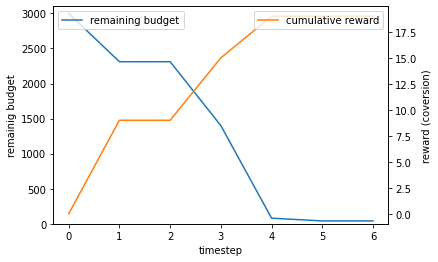

In [12]:
# let's visualize the transition of remaing budget and cumulative reward
# our goal is to gain a policy (i.e., agent) which maximize the cumulative reward under budget constraints using RL.  
# for more visulization, please see appendix.
obs = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

We see that the random policy soon run out the budget.  
Our goal is to derive a policy that controls the adjust rate (i.e., action) to maximize the reward within the given budget constraints.

We have following environmental configurations:
- `objective`: Objective KPIs of RTB, which is either "click" or "conversion".
- `step_per_episode`: Number of timesteps in an episode.
- `initial_budget`: Initial budget (i.e., constraint) for bidding during an episode.
- `n_ads`: Number of ads used for auction bidding.
- `n_users`: Number of users used for auction bidding.
- `ad_feature_dim`: Dimensions of the ad feature vectors.
- `user_feature_dim`: Dimensions of the user feature vectors.
- `ad_sampling_rate`: Sampling probalities to determine which ad (id) is used in each auction.
- `user_sampling_rate`: Sampling probalities to determine which user (id) is used in each auction.
- `standard_bid_price_distribution`: Distribution of the bid price whose average impression probability is expected to be 0.5.
- `minimum_standard_bid_price`: Minimum value for standard bid price.
- `trend_interval`: Length of the CTR/CVR trend cycle, where we define CTR as click per impression and CVR as conversion per click.
- `search_volume_distribution`: Search volume distribution for each timestep.
- `minimum_search_volume`: Minimum search volume at each timestep.
- `random_state`: Random state.

Please also see `_gym/env/rtb.py` for details.

#### Customization of RTB Env from decison makers' perspective
Here, we describe how the decision makers customize their own RTB environment.  
Specifically, they can setup their own action space and bid price calculation rules by defining the following modules.
- `reward_predictor` in Bidder class  
    We use predicted rewards to calculate bid price.  
        bid price = adjust rate * predicted reward ( * constant)
    If None, we use ground-truth reward instead of predicted reward.  

- `scaler` in Bidder class
    Scaler defines constant in the bid price calculation.  
        bid price = adjust rate * predicted reward ( * constant)
        constant = scaler * standard_bid_price
    where standard_bid_price indicates the average of standard_bid_price  
    (bid price which has approximately 50% impression probability) over all ads.

- `action_space` for agent  
    We transform continual adjust rate space [0, \infty) into agent action space [0.1, 10].  
    Both discrete and continuous actions are acceptable.  
    (We can tune multiplication of adjust rate using scaler.)
    
The arguments are given as follows:
- `original_env`: Original RTB Environment.
- `reward_predictor`: A machine learning model to predict the reward to determine the bidding price.
- `scaler`: Scaling factor (constant value) used for bid price determination. (`None` for the auto-fitting)
- `action_type`: Action type of the RL agent, which is either "discrete" or "continuous".
- `action_dim`: Dimention of "discrete" action.
- `action_meaning`: Mapping function of agent action index to the actual "discrete" action to take.

In [13]:
# now, let's customize the environment and discretize action space
env = CustomizedRTBEnv(
    original_env=env,
    reward_predictor=LogisticRegression(),
    action_type="discrete",
)

In [14]:
agent = OnlineHead(DiscreteRandomPolicy())
agent.build_with_env(env)  # set discrete action space

In [15]:
# interact agent with environment
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [16]:
print(env.action_space)
print(env.action_meaning)

Discrete(10)
[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


#### Online RL and comparison of the policies
Noe, we learn an online RL policy and compare it to random policy, using on-policy policy estimation.

In [17]:
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [18]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
)

2021-10-19 12:02.25 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20211019120225
2021-10-19 12:02.25 [debug    ] Building model...
2021-10-19 12:02.25 [debug    ] Model has been built.
2021-10-19 12:02.25 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_reduction_type': 'min', 'target_update_interval': 100, 'use_gpu': None, 'algorithm

  1%|          | 969/100000 [00:02<04:09, 396.56it/s]

2021-10-19 12:02.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_1000.pt
2021-10-19 12:02.27 [info     ] DoubleDQN_online_20211019120225: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00032292819023132326, 'time_environment_step': 0.0005946358272007534, 'time_step': 0.0022798020839691164, 'time_sample_batch': 8.173548420146495e-05, 'time_algorithm_update': 0.0013476789678492401, 'loss': 148.85562519616178, 'evaluation': 0.0} step=1000


  2%|▏         | 1949/100000 [00:04<03:10, 515.01it/s]

2021-10-19 12:02.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_2000.pt
2021-10-19 12:02.29 [info     ] DoubleDQN_online_20211019120225: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0002710220813751221, 'time_environment_step': 0.00048703139168875556, 'time_sample_batch': 6.664490699768066e-05, 'time_algorithm_update': 0.0011185483932495118, 'loss': 28.001199929237366, 'time_step': 0.0019316000938415527, 'evaluation': 0.0} step=2000


  3%|▎         | 2963/100000 [00:06<03:22, 479.68it/s]

2021-10-19 12:02.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_3000.pt
2021-10-19 12:02.31 [info     ] DoubleDQN_online_20211019120225: epoch=3 step=3000 epoch=3 metrics={'time_inference': 0.00027968454360961917, 'time_environment_step': 0.0005100767953055246, 'time_sample_batch': 7.106471061706543e-05, 'time_algorithm_update': 0.0011683382987976074, 'loss': 24.745248813152312, 'time_step': 0.002016525745391846, 'evaluation': 0.0} step=3000


  4%|▍         | 3984/100000 [00:08<03:22, 473.33it/s]

2021-10-19 12:02.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_4000.pt
2021-10-19 12:02.34 [info     ] DoubleDQN_online_20211019120225: epoch=4 step=4000 epoch=4 metrics={'time_inference': 0.0002908823490142822, 'time_environment_step': 0.000534402847290039, 'time_sample_batch': 7.770586013793946e-05, 'time_algorithm_update': 0.0012206258773803712, 'loss': 24.36558148777485, 'time_step': 0.002110706329345703, 'evaluation': 0.0} step=4000


  5%|▍         | 4984/100000 [00:10<03:21, 472.27it/s]

2021-10-19 12:02.36 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_5000.pt
2021-10-19 12:02.36 [info     ] DoubleDQN_online_20211019120225: epoch=5 step=5000 epoch=5 metrics={'time_inference': 0.00029341959953308106, 'time_environment_step': 0.0005418390546526227, 'time_sample_batch': 7.828855514526367e-05, 'time_algorithm_update': 0.0012296030521392822, 'loss': 23.13710854256153, 'time_step': 0.002130830526351929, 'evaluation': 0.0} step=5000


  6%|▌         | 5972/100000 [00:12<03:10, 494.63it/s]

2021-10-19 12:02.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_6000.pt
2021-10-19 12:02.38 [info     ] DoubleDQN_online_20211019120225: epoch=6 step=6000 epoch=6 metrics={'time_inference': 0.00027992296218872073, 'time_environment_step': 0.0005181418827601841, 'time_sample_batch': 7.433581352233886e-05, 'time_algorithm_update': 0.001184061050415039, 'loss': 20.788883772075177, 'time_step': 0.00204398250579834, 'evaluation': 0.0} step=6000


  7%|▋         | 6969/100000 [00:15<03:18, 467.61it/s]

2021-10-19 12:02.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_7000.pt
2021-10-19 12:02.40 [info     ] DoubleDQN_online_20211019120225: epoch=7 step=7000 epoch=7 metrics={'time_inference': 0.0002955822944641113, 'time_environment_step': 0.0005159808567592076, 'time_sample_batch': 7.405495643615722e-05, 'time_algorithm_update': 0.001188469648361206, 'loss': 19.096451235055923, 'time_step': 0.0020620641708374026, 'evaluation': 0.0} step=7000


  8%|▊         | 7970/100000 [00:17<03:06, 493.89it/s]

2021-10-19 12:02.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_8000.pt
2021-10-19 12:02.42 [info     ] DoubleDQN_online_20211019120225: epoch=8 step=8000 epoch=8 metrics={'time_inference': 0.00028297710418701173, 'time_environment_step': 0.0005110173906598773, 'time_sample_batch': 7.38675594329834e-05, 'time_algorithm_update': 0.0011798484325408936, 'loss': 17.101798341989518, 'time_step': 0.002036055088043213, 'evaluation': 0.0} step=8000


  9%|▉         | 8996/100000 [00:19<03:20, 453.52it/s]

2021-10-19 12:02.45 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_9000.pt
2021-10-19 12:02.45 [info     ] DoubleDQN_online_20211019120225: epoch=9 step=9000 epoch=9 metrics={'time_inference': 0.00030826067924499514, 'time_environment_step': 0.0005569804055350167, 'time_sample_batch': 8.21084976196289e-05, 'time_algorithm_update': 0.0012667684555053712, 'loss': 14.681160207927228, 'time_step': 0.002200603485107422, 'evaluation': 0.1} step=9000


 10%|▉         | 9967/100000 [00:21<03:24, 440.86it/s]

2021-10-19 12:02.47 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_10000.pt
2021-10-19 12:02.47 [info     ] DoubleDQN_online_20211019120225: epoch=10 step=10000 epoch=10 metrics={'time_inference': 0.00030416178703308107, 'time_environment_step': 0.0005608703068324497, 'time_sample_batch': 8.265781402587891e-05, 'time_algorithm_update': 0.001271481990814209, 'loss': 12.648063660264015, 'time_step': 0.002205730199813843, 'evaluation': 0.0} step=10000


 11%|█         | 10950/100000 [00:23<03:00, 492.45it/s]

2021-10-19 12:02.49 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_11000.pt
2021-10-19 12:02.49 [info     ] DoubleDQN_online_20211019120225: epoch=11 step=11000 epoch=11 metrics={'time_inference': 0.0002851886749267578, 'time_environment_step': 0.0005224345070975168, 'time_sample_batch': 7.61258602142334e-05, 'time_algorithm_update': 0.001188843011856079, 'loss': 10.922377593427896, 'time_step': 0.0020595858097076417, 'evaluation': 0.0} step=11000


 12%|█▏        | 11995/100000 [00:25<02:56, 499.90it/s]

2021-10-19 12:02.51 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_12000.pt
2021-10-19 12:02.51 [info     ] DoubleDQN_online_20211019120225: epoch=12 step=12000 epoch=12 metrics={'time_inference': 0.0002761826515197754, 'time_environment_step': 0.0005065882546561105, 'time_sample_batch': 7.419562339782715e-05, 'time_algorithm_update': 0.001169435739517212, 'loss': 9.944520580291748, 'time_step': 0.002015071392059326, 'evaluation': 0.0} step=12000


 13%|█▎        | 12969/100000 [00:27<02:52, 505.37it/s]

2021-10-19 12:02.53 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_13000.pt
2021-10-19 12:02.53 [info     ] DoubleDQN_online_20211019120225: epoch=13 step=13000 epoch=13 metrics={'time_inference': 0.00027128148078918457, 'time_environment_step': 0.0004968291691371373, 'time_sample_batch': 7.240891456604004e-05, 'time_algorithm_update': 0.0011464064121246339, 'loss': 8.537946338057518, 'time_step': 0.0019766693115234376, 'evaluation': 0.0} step=13000


 14%|█▍        | 13991/100000 [00:30<02:52, 499.91it/s]

2021-10-19 12:02.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_14000.pt
2021-10-19 12:02.55 [info     ] DoubleDQN_online_20211019120225: epoch=14 step=14000 epoch=14 metrics={'time_inference': 0.00026959586143493654, 'time_environment_step': 0.0004983719417027064, 'time_sample_batch': 7.272505760192871e-05, 'time_algorithm_update': 0.0011475200653076171, 'loss': 6.290522886782885, 'time_step': 0.0019774980545043943, 'evaluation': 14.0} step=14000


 15%|█▍        | 14997/100000 [00:32<02:50, 499.76it/s]

2021-10-19 12:02.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_15000.pt
2021-10-19 12:02.57 [info     ] DoubleDQN_online_20211019120225: epoch=15 step=15000 epoch=15 metrics={'time_inference': 0.00027451372146606445, 'time_environment_step': 0.0005022174290248326, 'time_sample_batch': 7.354593276977539e-05, 'time_algorithm_update': 0.0011609458923339843, 'loss': 4.965999378561974, 'time_step': 0.0020010266304016115, 'evaluation': 0.0} step=15000


 16%|█▌        | 15980/100000 [00:34<02:47, 502.53it/s]

2021-10-19 12:02.59 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_16000.pt
2021-10-19 12:02.59 [info     ] DoubleDQN_online_20211019120225: epoch=16 step=16000 epoch=16 metrics={'time_inference': 0.00028207564353942874, 'time_environment_step': 0.0005201413290841239, 'time_sample_batch': 7.644176483154297e-05, 'time_algorithm_update': 0.00119488525390625, 'loss': 4.204005345582962, 'time_step': 0.00206220269203186, 'evaluation': 16.8} step=16000


 17%|█▋        | 16979/100000 [00:36<02:57, 467.55it/s]

2021-10-19 12:03.01 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_17000.pt
2021-10-19 12:03.01 [info     ] DoubleDQN_online_20211019120225: epoch=17 step=17000 epoch=17 metrics={'time_inference': 0.0002832889556884766, 'time_environment_step': 0.0005219219752720424, 'time_sample_batch': 7.696104049682617e-05, 'time_algorithm_update': 0.001197669744491577, 'loss': 3.016337691128254, 'time_step': 0.002068873405456543, 'evaluation': 14.1} step=17000


 18%|█▊        | 17984/100000 [00:38<02:46, 491.37it/s]

2021-10-19 12:03.04 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_18000.pt
2021-10-19 12:03.04 [info     ] DoubleDQN_online_20211019120225: epoch=18 step=18000 epoch=18 metrics={'time_inference': 0.00027598094940185547, 'time_environment_step': 0.0005082609994070871, 'time_sample_batch': 7.404541969299317e-05, 'time_algorithm_update': 0.0011683189868927002, 'loss': 2.594809011757374, 'time_step': 0.0020155346393585204, 'evaluation': 16.7} step=18000


 19%|█▉        | 18980/100000 [00:40<02:42, 499.40it/s]

2021-10-19 12:03.06 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_19000.pt
2021-10-19 12:03.06 [info     ] DoubleDQN_online_20211019120225: epoch=19 step=19000 epoch=19 metrics={'time_inference': 0.0002764153480529785, 'time_environment_step': 0.0005096950531005859, 'time_sample_batch': 7.418560981750488e-05, 'time_algorithm_update': 0.0011724755764007568, 'loss': 2.410167052447796, 'time_step': 0.002021531343460083, 'evaluation': 18.6} step=19000


 20%|█▉        | 19969/100000 [00:42<02:58, 447.36it/s]

2021-10-19 12:03.08 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_20000.pt
2021-10-19 12:03.08 [info     ] DoubleDQN_online_20211019120225: epoch=20 step=20000 epoch=20 metrics={'time_inference': 0.0002863590717315674, 'time_environment_step': 0.0005272960662841797, 'time_sample_batch': 7.718753814697265e-05, 'time_algorithm_update': 0.0012194876670837402, 'loss': 2.2874440818428994, 'time_step': 0.0020992815494537353, 'evaluation': 13.6} step=20000


 21%|██        | 20989/100000 [00:44<02:42, 485.24it/s]

2021-10-19 12:03.10 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_21000.pt
2021-10-19 12:03.10 [info     ] DoubleDQN_online_20211019120225: epoch=21 step=21000 epoch=21 metrics={'time_inference': 0.0002835416793823242, 'time_environment_step': 0.0005274083273751395, 'time_sample_batch': 7.704091072082519e-05, 'time_algorithm_update': 0.0012101364135742188, 'loss': 2.3868587073385714, 'time_step': 0.0020861389636993408, 'evaluation': 16.8} step=21000


 22%|██▏       | 21950/100000 [00:46<02:36, 499.89it/s]

2021-10-19 12:03.12 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_22000.pt
2021-10-19 12:03.12 [info     ] DoubleDQN_online_20211019120225: epoch=22 step=22000 epoch=22 metrics={'time_inference': 0.00027073168754577636, 'time_environment_step': 0.0004982525961739676, 'time_sample_batch': 7.280254364013672e-05, 'time_algorithm_update': 0.0011504430770874023, 'loss': 1.9095990878343583, 'time_step': 0.001981978416442871, 'evaluation': 19.5} step=22000


 23%|██▎       | 22971/100000 [00:49<02:34, 499.65it/s]

2021-10-19 12:03.14 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_23000.pt
2021-10-19 12:03.14 [info     ] DoubleDQN_online_20211019120225: epoch=23 step=23000 epoch=23 metrics={'time_inference': 0.0002706925868988037, 'time_environment_step': 0.0004989286150251116, 'time_sample_batch': 7.255721092224121e-05, 'time_algorithm_update': 0.0011487622261047363, 'loss': 1.94503540712595, 'time_step': 0.001980095863342285, 'evaluation': 18.7} step=23000


 24%|██▍       | 23988/100000 [00:51<02:32, 499.39it/s]

2021-10-19 12:03.16 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_24000.pt
2021-10-19 12:03.16 [info     ] DoubleDQN_online_20211019120225: epoch=24 step=24000 epoch=24 metrics={'time_inference': 0.0002751944065093994, 'time_environment_step': 0.0005067885262625558, 'time_sample_batch': 7.383942604064941e-05, 'time_algorithm_update': 0.0011680212020874024, 'loss': 1.87504739639163, 'time_step': 0.0020128819942474363, 'evaluation': 17.1} step=24000


 25%|██▍       | 24976/100000 [00:53<02:35, 481.11it/s]

2021-10-19 12:03.18 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_25000.pt
2021-10-19 12:03.18 [info     ] DoubleDQN_online_20211019120225: epoch=25 step=25000 epoch=25 metrics={'time_inference': 0.0002814404964447021, 'time_environment_step': 0.0005227058955601284, 'time_sample_batch': 7.737803459167481e-05, 'time_algorithm_update': 0.0012037408351898192, 'loss': 1.6781084852218628, 'time_step': 0.0020741240978240966, 'evaluation': 15.4} step=25000


 26%|██▌       | 25954/100000 [00:55<02:37, 469.72it/s]

2021-10-19 12:03.21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_26000.pt
2021-10-19 12:03.21 [info     ] DoubleDQN_online_20211019120225: epoch=26 step=26000 epoch=26 metrics={'time_inference': 0.000285632848739624, 'time_environment_step': 0.0005268919808523996, 'time_sample_batch': 7.710361480712891e-05, 'time_algorithm_update': 0.001211439371109009, 'loss': 1.5216676220297813, 'time_step': 0.002089277744293213, 'evaluation': 17.6} step=26000


 27%|██▋       | 26990/100000 [00:57<02:30, 486.22it/s]

2021-10-19 12:03.23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_27000.pt
2021-10-19 12:03.23 [info     ] DoubleDQN_online_20211019120225: epoch=27 step=27000 epoch=27 metrics={'time_inference': 0.0002812056541442871, 'time_environment_step': 0.0005138819558279854, 'time_sample_batch': 7.56220817565918e-05, 'time_algorithm_update': 0.0011894919872283936, 'loss': 1.4553064702153207, 'time_step': 0.002049593448638916, 'evaluation': 16.7} step=27000


 28%|██▊       | 27974/100000 [00:59<02:35, 463.32it/s]

2021-10-19 12:03.25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_28000.pt
2021-10-19 12:03.25 [info     ] DoubleDQN_online_20211019120225: epoch=28 step=28000 epoch=28 metrics={'time_inference': 0.0002822883129119873, 'time_environment_step': 0.0005219742911202567, 'time_sample_batch': 7.649779319763184e-05, 'time_algorithm_update': 0.0012029781341552734, 'loss': 1.2948598902225494, 'time_step': 0.0020722484588623045, 'evaluation': 19.5} step=28000


 29%|██▉       | 28968/100000 [01:01<02:29, 474.08it/s]

2021-10-19 12:03.27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_29000.pt
2021-10-19 12:03.27 [info     ] DoubleDQN_online_20211019120225: epoch=29 step=29000 epoch=29 metrics={'time_inference': 0.00028090190887451174, 'time_environment_step': 0.0005164710453578404, 'time_sample_batch': 7.569646835327149e-05, 'time_algorithm_update': 0.0011931681632995606, 'loss': 1.3184351392388345, 'time_step': 0.0020548062324523926, 'evaluation': 18.3} step=29000


 30%|██▉       | 29968/100000 [01:03<02:23, 486.58it/s]

2021-10-19 12:03.29 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_30000.pt
2021-10-19 12:03.29 [info     ] DoubleDQN_online_20211019120225: epoch=30 step=30000 epoch=30 metrics={'time_inference': 0.0002751173973083496, 'time_environment_step': 0.0005084217616489955, 'time_sample_batch': 7.384872436523438e-05, 'time_algorithm_update': 0.0011742861270904541, 'loss': 1.2908088007569314, 'time_step': 0.0020205466747283936, 'evaluation': 20.4} step=30000


 31%|███       | 30978/100000 [01:06<02:18, 498.09it/s]

2021-10-19 12:03.31 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_31000.pt
2021-10-19 12:03.31 [info     ] DoubleDQN_online_20211019120225: epoch=31 step=31000 epoch=31 metrics={'time_inference': 0.0002741060256958008, 'time_environment_step': 0.0005019280569893974, 'time_sample_batch': 7.320809364318848e-05, 'time_algorithm_update': 0.0011622748374938965, 'loss': 1.3035709580779076, 'time_step': 0.0020008611679077147, 'evaluation': 5.9} step=31000


 32%|███▏      | 31975/100000 [01:08<02:26, 465.80it/s]

2021-10-19 12:03.33 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_32000.pt
2021-10-19 12:03.33 [info     ] DoubleDQN_online_20211019120225: epoch=32 step=32000 epoch=32 metrics={'time_inference': 0.00028399395942687987, 'time_environment_step': 0.000521073750087193, 'time_sample_batch': 7.614946365356445e-05, 'time_algorithm_update': 0.0012002277374267578, 'loss': 1.3377116855084896, 'time_step': 0.0020707170963287355, 'evaluation': 17.5} step=32000


 33%|███▎      | 32980/100000 [01:10<02:14, 499.01it/s]

2021-10-19 12:03.35 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_33000.pt
2021-10-19 12:03.35 [info     ] DoubleDQN_online_20211019120225: epoch=33 step=33000 epoch=33 metrics={'time_inference': 0.00027400684356689454, 'time_environment_step': 0.0005034956250871931, 'time_sample_batch': 7.352566719055176e-05, 'time_algorithm_update': 0.0011626756191253662, 'loss': 1.2972745654881002, 'time_step': 0.002003077745437622, 'evaluation': 17.2} step=33000


 34%|███▍      | 33969/100000 [01:12<02:19, 471.78it/s]

2021-10-19 12:03.38 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_34000.pt
2021-10-19 12:03.38 [info     ] DoubleDQN_online_20211019120225: epoch=34 step=34000 epoch=34 metrics={'time_inference': 0.0002957797050476074, 'time_environment_step': 0.0005460839952741351, 'time_sample_batch': 8.099913597106934e-05, 'time_algorithm_update': 0.0012583177089691162, 'loss': 1.3191424544155597, 'time_step': 0.0021752440929412842, 'evaluation': 16.2} step=34000


 35%|███▍      | 34956/100000 [01:14<02:22, 455.19it/s]

2021-10-19 12:03.40 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_35000.pt
2021-10-19 12:03.40 [info     ] DoubleDQN_online_20211019120225: epoch=35 step=35000 epoch=35 metrics={'time_inference': 0.00029607391357421877, 'time_environment_step': 0.0005507362910679408, 'time_sample_batch': 8.108186721801758e-05, 'time_algorithm_update': 0.0012555296421051026, 'loss': 1.3115265748798848, 'time_step': 0.0021718614101409912, 'evaluation': 1.0} step=35000


 36%|███▌      | 35978/100000 [01:16<02:10, 489.87it/s]

2021-10-19 12:03.42 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20211019120225/model_36000.pt
2021-10-19 12:03.42 [info     ] DoubleDQN_online_20211019120225: epoch=36 step=36000 epoch=36 metrics={'time_inference': 0.00028210067749023435, 'time_environment_step': 0.000519416264125279, 'time_sample_batch': 7.538223266601562e-05, 'time_algorithm_update': 0.0011959786415100097, 'loss': 1.2232856658399105, 'time_step': 0.002062094211578369, 'evaluation': 17.0} step=36000


 37%|███▋      | 36509/100000 [01:18<02:15, 467.40it/s]


KeyboardInterrupt: 

In [ ]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [ ]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

In [ ]:
log_path = sorted(glob("d3rlpy_logs/DoubleDQN_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of DDQN")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [ ]:
random = DiscreteRandomPolicy()
random.build_with_env(env)

In [ ]:
# compare performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, random],
    policy_names=["ddqn", "random"],
    n_episodes=100,
    random_state=random_state,
)

In [ ]:
# on-policy policy value by dqn policy
ddqn_performance = calc_on_policy_policy_value(env, ddqn, n_episodes=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_episodes=100, random_state=random_state)
print("relative improvement:", (ddqn_performance - random_performance) / random_performance)

## 1. Synthetic Dataset Generation
In the previous section, we see how we can interact the environment *online* using synthetic simulator.  
Though simulation is a good start for training agent, eventually we want to deploy our agent (or policy) in the real world environment.  
However, online interaction may have potential risk of failure in real-world implementataion.  
Therefore, we introduce alternative learning protocol, Offline RL, which aim to obtain a new policy using only offline logged dataset.

We prepare easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding simulation environment as a hypothetical real-environment, we show how to conduct Offline RL using logged dataset in real-world application.  
For detailed description of how to use real-world dataset, please see #TODO (will be implemented).

We have following arguments for `SyntheticDataset` class:
- `env`: RTB environment for RL defined in the previous section.
- `bahavior_policy`: RL agent (or algorithm) used for the data collection.
- `n_samples_pretrain_reward_predictor`: Numbers of samples used to pretrain reward predictor.

In [ ]:
behavior_policy = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
)

In [ ]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    random_state=random_state,
)

In [ ]:
# collect logged data using behavior policy
# skip if there is a preserved logged dataset
logged_dataset = dataset.obtain_trajectories(n_episodes=10000)

In [ ]:
logged_dataset

In [ ]:
with open("logs/dataset_discrete.pkl", "wb") as f:
    pickle.dump(logged_dataset, f)

In [ ]:
with open("logs/dataset_discrete.pkl", "rb") as f:
    logged_dataset = pickle.load(f)

In [ ]:
# compare performance online
# almost same performance with greedy ddqn
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "random"],
    n_episodes=100,
    random_state=random_state,
)

In [ ]:
# check statistics of the dataset
# for more info, please refer the visualization in appendix
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting to the environment.  
To achieve this goal, we exploit logged dataset and train the policy on the data.  
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of algorithms.

In [ ]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL
from d3rlpy.ope import DiscreteFQE
from d3rlpy.metrics.scorer import evaluate_on_environment

In [ ]:
offlinerl_dataset = MDPDataset(
    observations=logged_dataset["state"],
    actions=logged_dataset["action"],
    rewards=logged_dataset["reward"],
    terminals=logged_dataset["done"],
    episode_terminals=logged_dataset["done"],
    discrete_action=True,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [ ]:
# Use Conservetive Q-Learning policy
cql = DiscreteCQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [ ]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={
        'environment': evaluate_on_environment(env),
        # to record training process w/ ground truth policy value, which is unseen to the agent
    },
)

In [37]:
# save model
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [34]:
# reload model
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

[calculate on-policy policy value]: 100%|██████████| 100/100 [00:00<00:00, 329.36it/s]


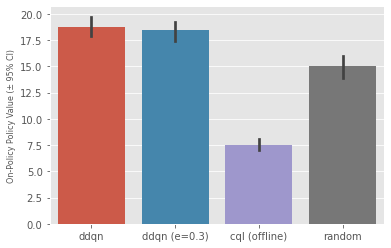

In [89]:
# compare performance online
# seems that cql fails..
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, cql, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "cql (offline)", "random"],
    n_episodes=100,
    random_state=random_state,
)

## 3. Off-Policy Evaluation and Evaluation of Offline RL methods
In the previous section, we verified the performance of learned policy via online interaction (aka A/B tests).  
However, it could be risky because the policy may perform poorly in an online environment.  
To tackle this issue, we aim to evaluate the performance of policies in an offline manner, to gain prior knowledge on how agent works in the environment.

In [36]:
# import ope modules from _gym
from _gym.ope import CreateOPEInput
from _gym.ope import OffPolicyEvaluation as OPE
from _gym.ope import DiscreteDirectMethod as DM
from _gym.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from _gym.ope import DiscreteStepWiseImportanceSampling as SIS
from _gym.ope import DiscreteDoublyRobust as DR

In [37]:
# define evaluation policies
cql_ = DiscreteEpsilonGreedyHead(base_algo=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0)
ddqn_ = DiscreteEpsilonGreedyHead(base_algo=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0)
random_ = DiscreteEpsilonGreedyHead(base_algo=ddqn, n_actions=env.action_space.n, name="random", epsilon=1.0)
evaluation_policies = [cql_, ddqn_, random_]

In [38]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    logged_dataset=logged_dataset,
    use_base_model=True,  # use model-based prediction
)

In [39]:
# takes time
input_dict = prep.obtain_whole_inputs(
    evaluation_policies=evaluation_policies,
    env=env,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/3 [00:00<?, ?it/s]

2021-10-19 09:33.24 [debug    ] RandomIterator is selected.
2021-10-19 09:33.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20211019093324
2021-10-19 09:33.24 [debug    ] Building models...
2021-10-19 09:33.24 [debug    ] Models have been built.
2021-10-19 09:33.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20211019093324/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gp

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-10-19 09:33.44 [info     ] DiscreteFQE_20211019093324: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000343846321105957, 'time_algorithm_update': 0.0015068894624710083, 'loss': 4.534895637273788, 'time_step': 0.002017672109603882} step=10000
2021-10-19 09:33.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20211019093324/model_10000.pt


[fit FQE model]:  33%|███▎      | 1/3 [00:20<00:41, 20.69s/it]

2021-10-19 09:33.45 [debug    ] RandomIterator is selected.
2021-10-19 09:33.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20211019093345
2021-10-19 09:33.45 [debug    ] Building models...
2021-10-19 09:33.45 [debug    ] Models have been built.
2021-10-19 09:33.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20211019093345/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gp

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-10-19 09:34.05 [info     ] DiscreteFQE_20211019093345: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00034228520393371584, 'time_algorithm_update': 0.0014839771747589112, 'loss': 4.053887207096815, 'time_step': 0.0019862094163894655} step=10000
2021-10-19 09:34.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20211019093345/model_10000.pt


[fit FQE model]:  67%|██████▋   | 2/3 [00:40<00:20, 20.38s/it]

2021-10-19 09:34.05 [debug    ] RandomIterator is selected.
2021-10-19 09:34.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20211019093405
2021-10-19 09:34.05 [debug    ] Building models...
2021-10-19 09:34.05 [debug    ] Models have been built.
2021-10-19 09:34.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20211019093405/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'bootstrap': False, 'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gp

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-10-19 09:34.25 [info     ] DiscreteFQE_20211019093405: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0003376091241836548, 'time_algorithm_update': 0.001492371678352356, 'loss': 3.1632694840967654, 'time_step': 0.001985574555397034} step=10000
2021-10-19 09:34.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20211019093405/model_10000.pt


[collect input data]: 100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


In [40]:
with open("logs/ope_input_dict_discrete.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [41]:
with open("logs/ope_input_dict_discrete.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [42]:
ope = OPE(
    logged_dataset=logged_dataset,
    ope_estimators=[DM(), TIS(), SIS(), DR()],
)

In [43]:
# performance estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [44]:
# estimated policy performance
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy      7.220000               1.000000
 dm            14.259813               1.975043
 tis            2.143893               0.296938
 sis            4.011081               0.555551
 dr            10.039065               1.390452,
 'ddqn':            policy_value  relative_policy_value
 on_policy     18.250000               1.000000
 dm             8.857195               0.485326
 tis           18.115577               0.992634
 sis           18.436783               1.010235
 dr            18.269047               1.001044,
 'random':            policy_value  relative_policy_value
 on_policy     15.900000               1.000000
 dm            10.513174               0.661206
 tis            5.074630               0.319159
 sis           12.916433               0.812354
 dr            15.019892               0.944647}

In [45]:
# estimated policy performance confidence intervals
policy_value_interval_df_dict

{'cql':           mean  95.0% CI (lower)  95.0% CI (upper)
 dm   14.259181         14.253184         14.265320
 tis   2.422600          0.000000          7.557224
 sis   4.029237          3.489242          4.668516
 dr   10.720645         -4.081384         17.443242,
 'ddqn':           mean  95.0% CI (lower)  95.0% CI (upper)
 dm    8.857226          8.856391          8.858201
 tis  18.053907         17.015793         18.992073
 sis  18.443129         17.865949         18.876683
 dr   18.266151         17.987883         18.542151,
 'random':           mean  95.0% CI (lower)  95.0% CI (upper)
 dm   10.513193         10.512774         10.513605
 tis   5.077008          3.451182          7.239261
 sis  12.932125         11.956290         14.085978
 dr   15.014136         14.325008         15.894586}

## 4. Evaluation of OPE methods
Now, we evaluate how well ope estimators estimated the policy value.

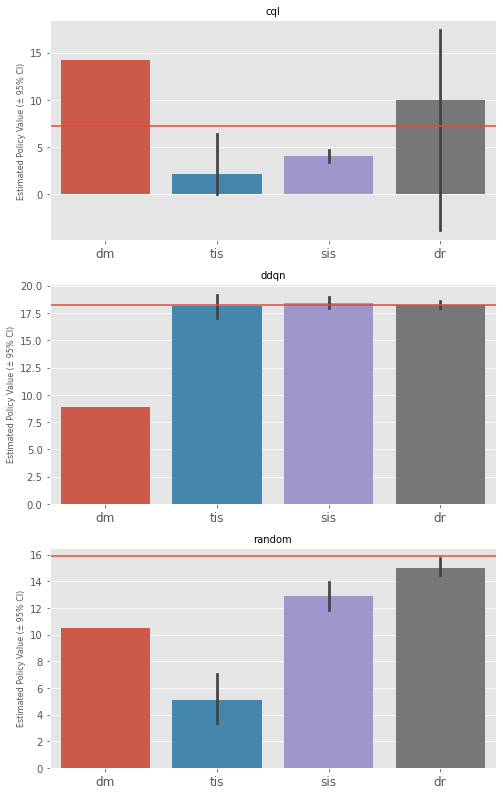

In [46]:
# we can visualize and compare the result
# it seems that DM tends to have a bias though the variance is quite small, 
# while importance sampling estimators have a smaller bias with a larger variance.
# somehow policy evaluation of DDQN policy seems quite hard.
ope.visualize_off_policy_estimates(input_dict, random_state)

In [47]:
# squared-error (se) measures the estimation accuracy of OPE
eval_metric_ope_df = ope.summarize_estimators_comparison(input_dict, metric="se")
eval_metric_ope_df

,cql,ddqn,random
dm,49.558974,88.224790,29.017899
tis,25.766859,0.018070,117.188634
sis,10.297163,0.034888,8.901671
dr,7.947129,0.000363,0.774590


## Appendix
Here we provide useful visualization function and insights of Synthetic RTB Simulation environment.

In [48]:
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.476244,77.918182,73.843714,7.846843,2.451500,0.399825,0.068953,0.176815
std,2.016298,108.165948,79.729366,8.836057,3.493389,0.397134,0.071906,0.209641
min,0.000151,3.863158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166810,6.957932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.774264,37.929643,44.000000,4.000000,1.000000,0.257768,0.077320,0.111111
75%,1.394072,64.544395,155.000000,15.000000,4.000000,0.811432,0.113636,0.333332
max,10.000000,567.695431,278.000000,45.000000,23.000000,1.000000,0.999997,0.999999


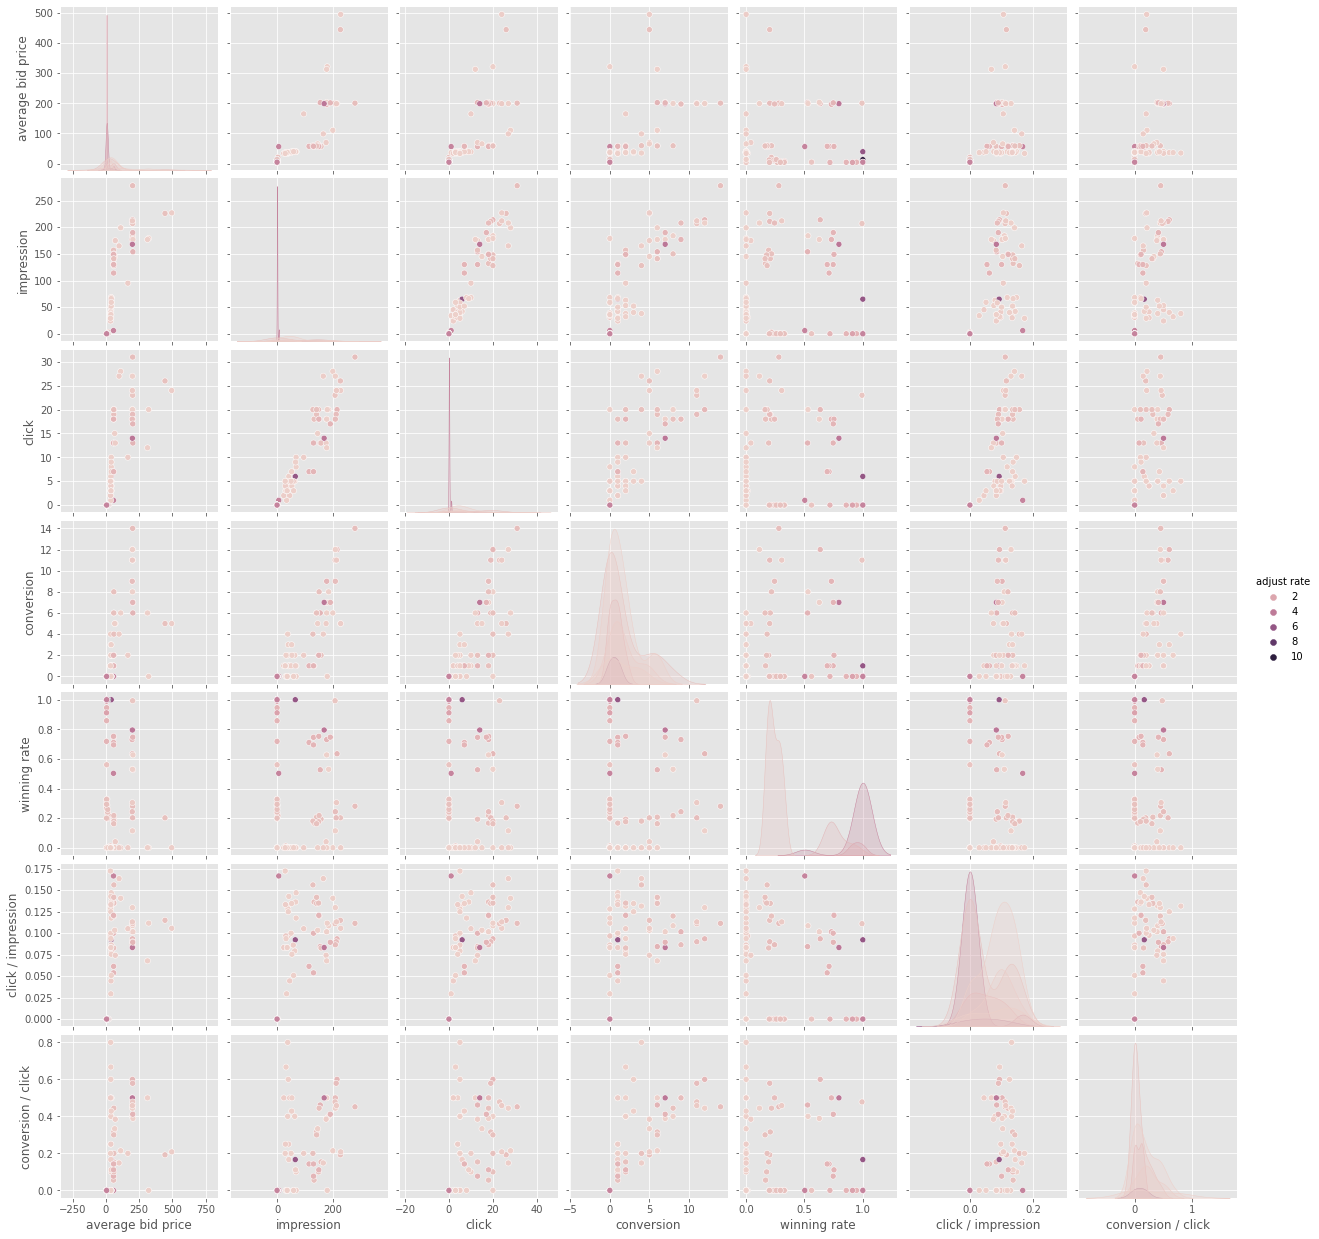

In [49]:
# we see that large adjust rate does not always lead to high reward (conversion) because of the budget constraints
# therefore, it is important to appropriately controling adjust rate parameter by RL policy (agent)
sns.pairplot(df[:100], hue='adjust rate')

In [50]:
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['ramaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]

In [51]:
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,ramaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,1.476244,77.918182,73.843714,7.846843,2.451500,808.88320
std,0.664030,35.230178,18.398934,2.068920,0.827431,775.59712
min,0.282961,13.225369,3.428571,0.285714,0.000000,1.00000
25%,1.004237,53.760479,63.285714,6.714286,1.857143,41.00000
50%,1.267726,66.799929,78.071429,8.714286,2.571429,603.00000
75%,1.812232,97.086485,86.428571,9.285714,3.000000,1511.25000
max,5.252725,302.903691,124.714286,11.142857,5.285714,2964.00000


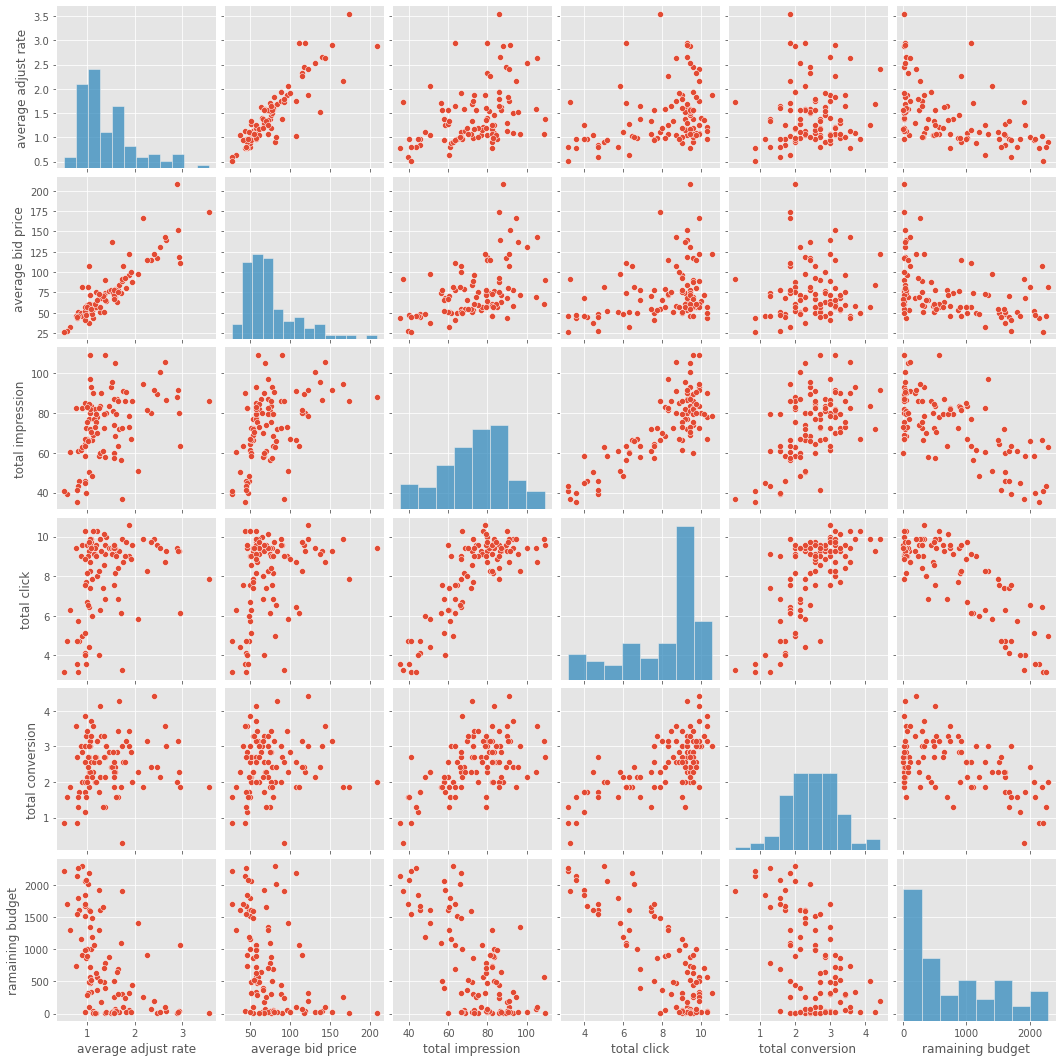

In [52]:
# not so much correlation between adjust rate and conversion, meaning that there are room for improvement
sns.pairplot(df_[:100])